In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import *
from sklearn.svm import SVC,LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
import glob
from tqdm import tqdm
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from scipy.ndimage.measurements import label

In [3]:
def bin_spatial(img ,size=(32,32)):
    features=cv2.resize(img, size)
    return features.ravel()

def color_hist(img, hist_bins=32, color_range=(0,256)):
    ch1=np.histogram(img[:,:,0], hist_bins, range=color_range)
    ch2=np.histogram(img[:,:,1], hist_bins, range=color_range)
    ch3=np.histogram(img[:,:,2], hist_bins, range=color_range)
    hist_features=np.hstack((ch1[0], ch2[0], ch3[0]))
    return hist_features
    
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, hist_bins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    
    #9) Return concatenated array of features
    return np.concatenate(img_features)

def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,spatial_size=(16,16),hist_bins=32,spatial_feet=True, hist_feet=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = cv2.imread(file)
        image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_feature=single_img_features(image, color_space=cspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feet, hist_feat=hist_feet, hog_feat=True)
        features.append(img_feature)
    
    # Return list of feature vectors
    return features

In [4]:
car_path=[]
notcar_path=[]
car_dir=os.listdir('vehicles')
notcar_dir=os.listdir('non-vehicles')
cars=[]
notcars=[]
for path in car_dir:
    car_path.append('vehicles'+'/'+path)
for path in notcar_dir:
    notcar_path.append('non-vehicles'+'/'+path)

for path in car_path:
    if os.path.isdir(path)==True:
        infile=glob.glob(path+'/'+'*.png')
        for img in infile:
            cars.append(img)

for path in notcar_path:
    if os.path.isdir(path)==True:
        infile=glob.glob(path+'/'+'*.png')
        for img in infile:
            notcars.append(img)

There are 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: uint8


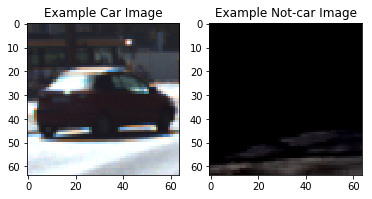

In [5]:
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] =  len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    # Define a key "image_shape" and store the test image shape 3-tuple
    test_img=cv2.imread(car_list[0])
    data_dict["image_shape"] = test_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = test_img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('There are', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')
plt.show()

In [6]:
car_features=extract_features(cars, cspace='YCrCb', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL',spatial_size=(16,16),hist_bins=32,
                             spatial_feet=True, hist_feet=True)
noncar_features=extract_features(notcars, cspace='YCrCb', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL',spatial_size=(16,16),
                                hist_bins=32, spatial_feet=True, hist_feet=True)



In [7]:
X = np.vstack((car_features, noncar_features)).astype(np.float64)  
scaler=StandardScaler()
X=scaler.fit_transform(X)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))
print(X.shape,y.shape)

(17760, 6156) (17760,)


In [20]:
X, y=shuffle(X, y)
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=0)
svc=LinearSVC(C=0.001, verbose=True, random_state=0)
svc.fit(X_train,y_train)
test_acc=svc.score(X_test, y_test)
print('The test accuracy is %.4f'%(test_acc))

[LibLinear]The test accuracy is 0.9916


In [9]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

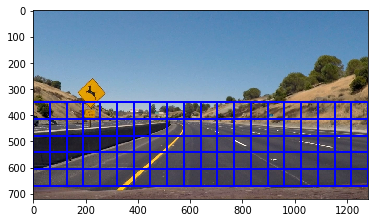

In [14]:
test_imgs=glob.glob('test_images/*.jpg')
image=mpimg.imread('test_images/test2.jpg')
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[350, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))             
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
plt.show()

In [10]:
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(16, 16), hist_bins=16, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    on_windows=[]
    for window in windows:
        test_img=img[window[0][1]:window[1][1],window[0][0]:window[1][0],:]
        test_img=cv2.resize(test_img, (64,64))
        feature=single_img_features(test_img, color_space=color_space, spatial_size=spatial_size,hist_bins=hist_bins,orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                   spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
        
        feature=scaler.transform(feature).reshape(1,-1)
        predict=clf.predict(feature)
        if predict==1:
            on_windows.append(window)
    return on_windows
        

In [11]:
def add_heat(image, hot_windows):
    mask=np.zeros_like(image[:,:,0])
    for window in hot_windows:
        mask[window[0][1]:window[1][1],window[0][0]:window[1][0]]+=1
    return mask

def apply_threshold(heat, threshold):
    heat[heat<threshold]=0
    return heat
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


In [91]:
test=cv2.imread(cars[0])
features=single_img_features(test, color_space='YCrCb', spatial_size=(16, 16),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True)

(768,) (96,) (5292,)


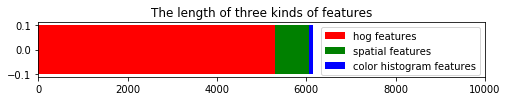

In [109]:
plt.figure(figsize=(8,1))
plt.barh(0.0, 5292, 0.2, color='r',left=0)
plt.barh(0.0, 768,0.2, color='g',left=5292)
plt.barh(0.0, 96, 0.2, color='b', left=5292+768)
plt.xlim(0,10000)
plt.legend(['hog features', 'spatial features', 'color histogram features'], loc='upper right')
plt.title('The length of three kinds of features')
plt.show()

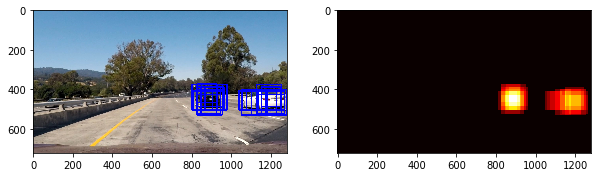

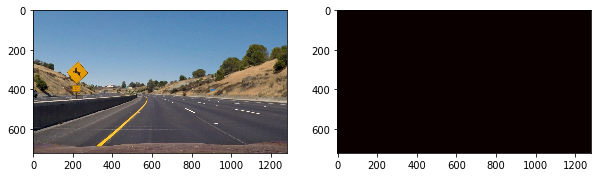

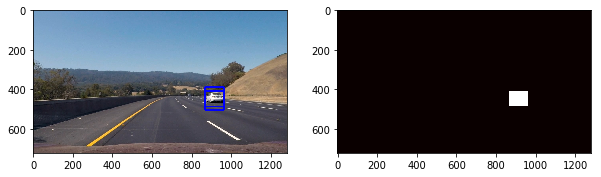

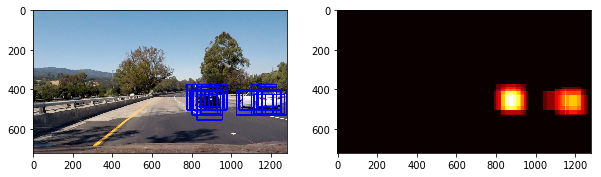

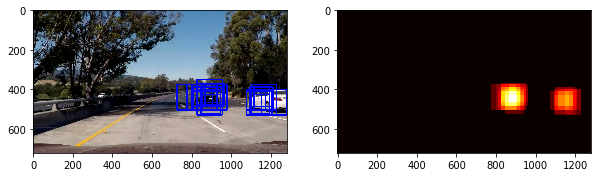

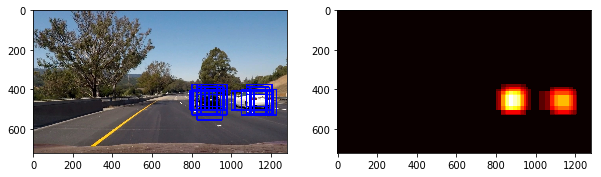

In [22]:
orient=9
spatial_size=16,16
hist_bins=32
pix_per_cell=8
cell_per_block=2
hog_channel='ALL'
xy_windows=[(96,96),(128,128)]
image_windows=[]
for name in test_imgs:
    image=cv2.imread(name)
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    total_windows=[]
    for xy_window in xy_windows:
        windows=slide_window(image, x_start_stop=[600, None], y_start_stop=[350, 660], 
                    xy_window=xy_window, xy_overlap=(0.8, 0.8))
        total_windows.extend(windows)
    
    hot_windows=search_windows(image, total_windows, svc, scaler, color_space='YCrCb', 
                    spatial_size=(16, 16), hist_bins=hist_bins, 
                    hist_range=(0, 256), orient=orient, 
                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                    hog_channel='ALL', spatial_feat=True, 
                    hist_feat=True, hog_feat=True)
    image_windows.append(hot_windows)
    draw_img=draw_boxes(image, hot_windows)
    heatmap=add_heat(image, hot_windows)
    heatmap=apply_threshold(heatmap, 2)
    plt.figure(figsize=(10,8))
    plt.subplot(1,2,1)
    plt.imshow(draw_img)
    plt.subplot(1,2,2)
    plt.imshow(heatmap,cmap='hot')
    plt.show()
        
        

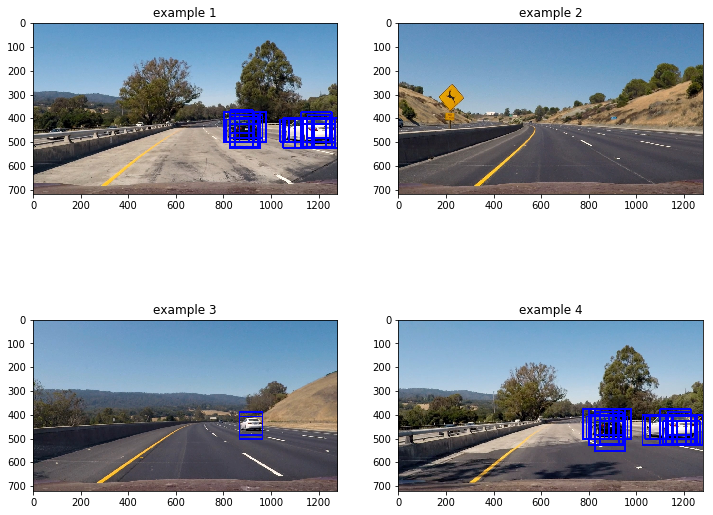

In [23]:
plt.figure(figsize=(12,10))
for i,name in enumerate(test_imgs[:4]):
    image=cv2.imread(name)
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    total_windows=[]
    for xy_window in xy_windows:
        windows=slide_window(image, x_start_stop=[600, None], y_start_stop=[350, 660], 
                    xy_window=xy_window, xy_overlap=(0.8, 0.8))
        total_windows.extend(windows)
    
    hot_windows=search_windows(image, total_windows, svc, scaler, color_space='YCrCb', 
                    spatial_size=(16, 16), hist_bins=hist_bins, 
                    hist_range=(0, 256), orient=orient, 
                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                    hog_channel='ALL', spatial_feat=True, 
                    hist_feat=True, hog_feat=True)
    image_windows.append(hot_windows)
    draw_img=draw_boxes(image, hot_windows)
    plt.subplot(2,2,i+1)
    plt.title('example %d'%(i+1))
    plt.imshow(draw_img)
    

plt.show()

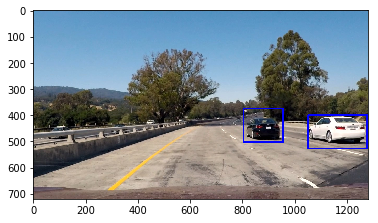

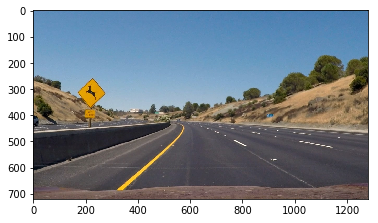

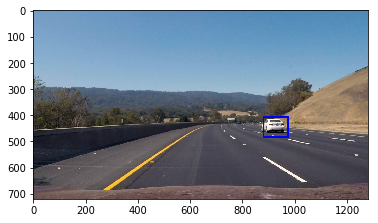

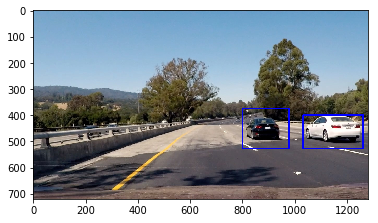

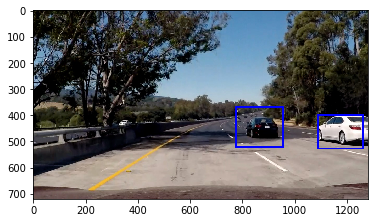

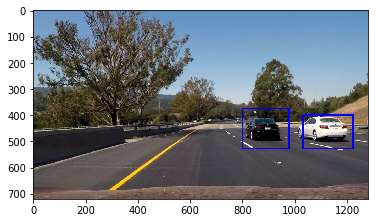

In [80]:
for i,name in enumerate(test_imgs):
    img=mpimg.imread(name)
    window_img = draw_boxes(img, image_windows[i], color=(0, 0, 255), thick=6)                    
    heatmap=add_heat(img, image_windows[i])
    heatmap=apply_threshold(heatmap, 2)
    labels=label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
# Display the image
    plt.imshow(draw_img)
    plt.show()

In [81]:
def preprocess(image):
    xy_windows=[(96,96),(128,128)]
    total_windows=[]
    for xy_window in xy_windows:
        windows = slide_window(image, x_start_stop=[600, None], y_start_stop=[350,660], 
                    xy_window=xy_window, xy_overlap=(0.8, 0.8))
        total_windows.extend(windows)
    

    hot_windows = search_windows(image, total_windows, svc, scaler, color_space='YCrCb', 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=True, 
                        hist_feat=True, hog_feat=True)                       
    window_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6)                    
    heatmap=add_heat(image, hot_windows)
    heatmap=apply_threshold(heatmap, 2)
    labels=label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img

In [82]:
output = 'test_video_output.mp4'
clip1 = VideoFileClip("test_video.mp4")
#clip1 = VideoFileClip("project_video.mp4").subclip(20,28)

out_clip = clip1.fl_image(preprocess) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [01:55<00:03,  3.13s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

Wall time: 1min 56s


In [83]:
output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
#clip1 = VideoFileClip("project_video.mp4").subclip(20,28)

out_clip = clip1.fl_image(preprocess) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|███████████████████████████████████████████████████████████████████████████▉| 1260/1261 [1:04:37<00:03,  3.04s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 1h 4min 38s
